In [1]:
#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-white')

## DATA COLLECTION

In [3]:
# Loading Customer demographics data
customer_demographics_df = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Customer_Demographics')
print(customer_demographics_df.shape)
customer_demographics_df.head()

(1000, 5)


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel
0,1,62,M,Single,Low
1,2,65,M,Married,Low
2,3,18,M,Single,Low
3,4,21,M,Widowed,Low
4,5,21,M,Divorced,Medium


In [4]:
# laoding transaction history data
transaction_history_df = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Transaction_History')
print(transaction_history_df.shape)
transaction_history_df.head()

(5054, 5)


,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory
0,1,7194,2022-03-27,416.50,Electronics
1,2,7250,2022-08-08,54.96,Clothing
2,2,9660,2022-07-25,197.50,Electronics
3,2,2998,2022-01-25,101.31,Furniture
4,2,1228,2022-07-24,397.37,Clothing


In [5]:
# loading customer service data
customer_service_df = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Customer_Service')
print(customer_service_df.shape)
customer_service_df.head()

(1002, 5)


,CustomerID,InteractionID,InteractionDate,InteractionType,ResolutionStatus
0,1,6363,2022-03-31,Inquiry,Resolved
1,2,3329,2022-03-17,Inquiry,Resolved
2,3,9976,2022-08-24,Inquiry,Resolved
3,4,7354,2022-11-18,Inquiry,Resolved
4,4,5393,2022-07-03,Inquiry,Unresolved


In [6]:
# loading online activity data
online_activity_df = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Online_Activity')
print(online_activity_df.shape)
online_activity_df.head()

(1000, 4)


,CustomerID,LastLoginDate,LoginFrequency,ServiceUsage
0,1,2023-10-21,34,Mobile App
1,2,2023-12-05,5,Website
2,3,2023-11-15,3,Website
3,4,2023-08-25,2,Website
4,5,2023-10-27,41,Website


In [7]:
# Loading churn status data
churn_status_df = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Churn_Status')
print(churn_status_df .shape)
churn_status_df .head()

(1000, 2)


,CustomerID,ChurnStatus
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [8]:
# Merging all the dataframes.
bank_df = pd.merge(customer_demographics_df, transaction_history_df, on ='CustomerID', how = 'outer' )
bank_df = pd.merge(bank_df, customer_service_df, on ='CustomerID', how = 'outer' )
bank_df = pd.merge(bank_df, online_activity_df, on ='CustomerID', how = 'outer' )
bank_df = pd.merge(bank_df, churn_status_df, on ='CustomerID', how = 'outer' )

In [9]:
# Saving the new data frame to csv
bank_df.to_csv('merged_bank_data.csv')

## EDA

### Data Understanding & Cleaning

In [12]:
# checking amount of rows and columns
bank_df.shape

(6812, 17)

In [13]:
# viewing the first 5 entries of the dataframe
bank_df.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TransactionID,TransactionDate,AmountSpent,ProductCategory,InteractionID,InteractionDate,InteractionType,ResolutionStatus,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,62,M,Single,Low,7194,2022-03-27,416.50,Electronics,6363.0,2022-03-31,Inquiry,Resolved,2023-10-21,34,Mobile App,0
1,2,65,M,Married,Low,7250,2022-08-08,54.96,Clothing,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
2,2,65,M,Married,Low,9660,2022-07-25,197.50,Electronics,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
3,2,65,M,Married,Low,2998,2022-01-25,101.31,Furniture,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
4,2,65,M,Married,Low,1228,2022-07-24,397.37,Clothing,3329.0,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1


In [14]:
# Anonymizing and dropping irrelevant columns
bank_df = bank_df.drop(['CustomerID','TransactionID','TransactionDate','InteractionID',
                        'InteractionDate','LastLoginDate'], axis=1)

In [15]:
# checking amount of rows and columns
bank_df.shape

(6812, 11)

In [16]:
# viewing the first 5 entries of the dataframe
bank_df.head()

,Age,Gender,MaritalStatus,IncomeLevel,AmountSpent,ProductCategory,InteractionType,ResolutionStatus,LoginFrequency,ServiceUsage,ChurnStatus
0,62,M,Single,Low,416.50,Electronics,Inquiry,Resolved,34,Mobile App,0
1,65,M,Married,Low,54.96,Clothing,Inquiry,Resolved,5,Website,1
2,65,M,Married,Low,197.50,Electronics,Inquiry,Resolved,5,Website,1
3,65,M,Married,Low,101.31,Furniture,Inquiry,Resolved,5,Website,1
4,65,M,Married,Low,397.37,Clothing,Inquiry,Resolved,5,Website,1


In [17]:
#checking for duplicates
bank_df.duplicated().sum()

284

In [18]:
# dropping the duplicates
bank_df = bank_df.drop_duplicates()
print(f' Duplicates: {bank_df.duplicated().sum()}')
bank_df.shape

 Duplicates: 0


(6528, 11)

In [19]:
#checking for the percentage of missing values
bank_df.isna().sum()/len(bank_df) * 100

Age                  0.000000
Gender               0.000000
MaritalStatus        0.000000
IncomeLevel          0.000000
AmountSpent          0.000000
ProductCategory      0.000000
InteractionType     24.632353
ResolutionStatus    24.632353
LoginFrequency       0.000000
ServiceUsage         0.000000
ChurnStatus          0.000000
dtype: float64

In [20]:
# unique values in interaction type
bank_df['InteractionType'].unique()

array(['Inquiry', nan, 'Feedback', 'Complaint'], dtype=object)

In [21]:
# unique values in resolution status
bank_df['ResolutionStatus'].unique()

array(['Resolved', 'Unresolved', nan], dtype=object)

In [22]:
# Handling missing values in interaction type
interactiontype_imputer = SimpleImputer(strategy='constant', fill_value='None')
bank_df[['InteractionType']] = interactiontype_imputer.fit_transform(bank_df[['InteractionType']])

In [23]:
# Handling missing values in Resolution Status
resolution_imputer = SimpleImputer(strategy='constant', fill_value='No Issue')
bank_df[['ResolutionStatus']] = resolution_imputer.fit_transform(bank_df[['ResolutionStatus']])

In [24]:
#checking for missing values
bank_df.isna().sum()

Age                 0
Gender              0
MaritalStatus       0
IncomeLevel         0
AmountSpent         0
ProductCategory     0
InteractionType     0
ResolutionStatus    0
LoginFrequency      0
ServiceUsage        0
ChurnStatus         0
dtype: int64

In [25]:
# Feature names and feature count
pd.DataFrame({'feature names':bank_df.columns, 'feature count':bank_df.nunique().values})

,feature names,feature count
0,Age,52
1,Gender,2
2,MaritalStatus,4
3,IncomeLevel,3
4,AmountSpent,4797
5,ProductCategory,5
6,InteractionType,4
7,ResolutionStatus,3
8,LoginFrequency,49
9,ServiceUsage,3


In [26]:
bank_df['ResolutionStatus'].unique()

array(['Resolved', 'Unresolved', 'No Issue'], dtype=object)

In [27]:
bank_df['InteractionType'].unique()

array(['Inquiry', 'None', 'Feedback', 'Complaint'], dtype=object)

### Formatting data types

In [29]:
# numerical columns
numerical_cols = ['Age','AmountSpent','LoginFrequency']

In [30]:
# nominal columns
nominal_cols = ['Gender','MaritalStatus','ProductCategory','InteractionType','ResolutionStatus','ServiceUsage']

In [31]:
# ordinal column
ordinal_col = ['IncomeLevel']

In [32]:
# Target column
target = ['ChurnStatus']

In [33]:
# converting the data type of the nominal columns to categorical.
for col in nominal_cols:
    bank_df[col] = pd.Categorical(bank_df[col], ordered=False)

In [34]:
# converting the data type of the ordinal column to ordered categories
bank_df['IncomeLevel'] = pd.Categorical(bank_df['IncomeLevel'], categories=['Low', 'Medium', 'High'], ordered=True)

In [35]:
# checking datatype
bank_df.dtypes

Age                    int64
Gender              category
MaritalStatus       category
IncomeLevel         category
AmountSpent          float64
ProductCategory     category
InteractionType     category
ResolutionStatus    category
LoginFrequency         int64
ServiceUsage        category
ChurnStatus            int64
dtype: object

In [36]:
bank_df.to_csv('cleaned_bank_data.csv')

### VISUALIZATION

#### Univariate Analysis

In [39]:
# Distribution of churnstatus (target)
bank_df['ChurnStatus'].value_counts()

ChurnStatus
0    5246
1    1282
Name: count, dtype: int64

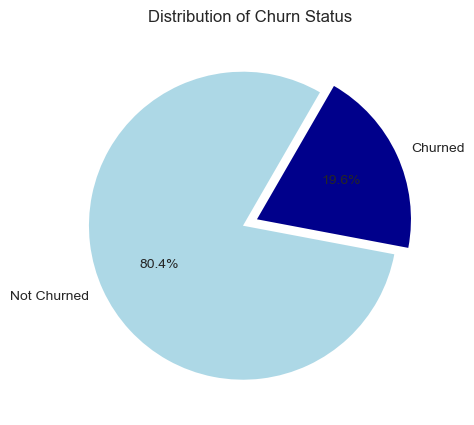

In [40]:
# Pie chart to visualize target.
plt.figure(figsize=(10, 5))
bank_df['ChurnStatus'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%',
    startangle=60,
    colors=['lightblue', 'darkblue'], 
    labels=['Not Churned', 'Churned'], 
    explode=[0.05, 0.05])
plt.title('Distribution of Churn Status')
plt.ylabel('')
plt.show()

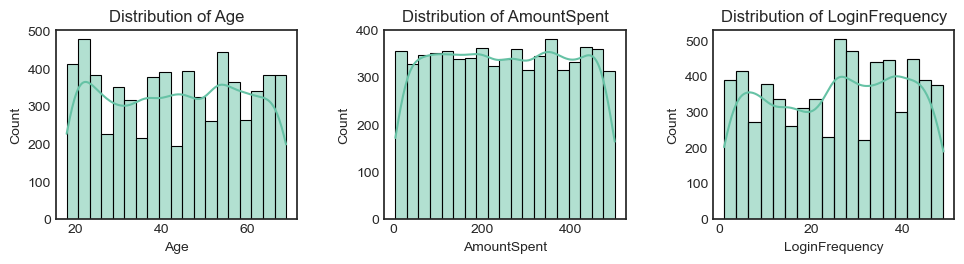

In [41]:
# plotting distribution of numeriacal features
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i, col in enumerate(numerical_cols):
    sns.histplot(bank_df[col], kde=True, ax=axes[i],edgecolor='black',color='#66C2A5')
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout(w_pad=3, pad=2)
plt.show()

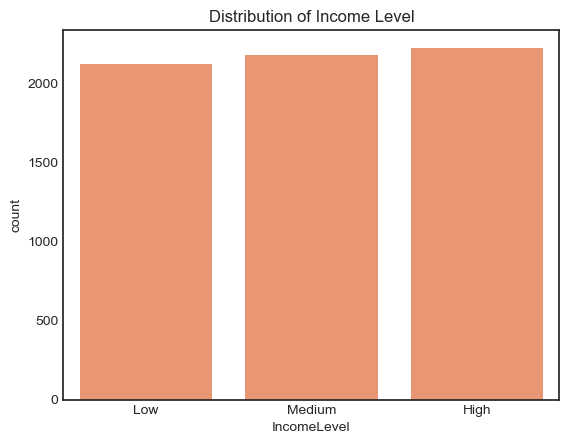

In [42]:
# Distribution of Income Level
sns.countplot(bank_df, x='IncomeLevel', color='#FC8D62')
plt.title('Distribution of Income Level')
plt.show()

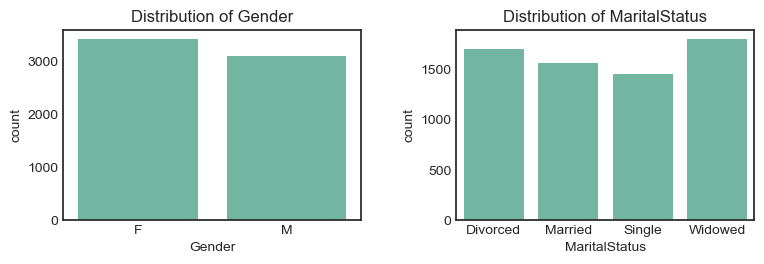

In [281]:
# distribution for age and marital status
fig, axes = plt.subplots(1,2, figsize=(8, 3))
axes = axes.flatten()
for i, col in enumerate(nominal_cols[:2]):
    sns.countplot(bank_df, x=col, ax=axes[i], color='#66C2A5')
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout(w_pad=3, pad=2)
plt.show()

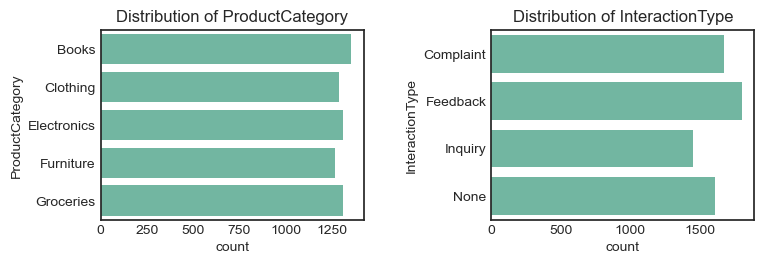

In [283]:
# distribution for product category  and interaction type
fig, axes = plt.subplots(1,2, figsize=(8, 3))
axes = axes.flatten()
for i, col in enumerate(nominal_cols[2:4]):
    sns.countplot(bank_df, y=col, ax=axes[i], color='#66C2A5')
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout(w_pad=3, pad=2)
plt.show()

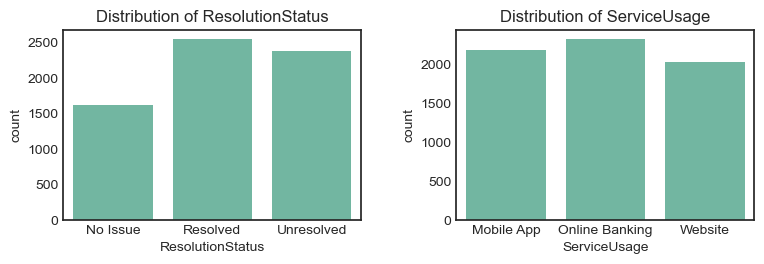

In [285]:
# distribution for Resolution status  and Service usage
fig, axes = plt.subplots(1,2, figsize=(8, 3))
axes = axes.flatten()
for i, col in enumerate(nominal_cols[4:]):
    sns.countplot(bank_df, x=col, ax=axes[i], color='#66C2A5')
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout(w_pad=3, pad=2)
plt.show()

#### Bivariate Analysis

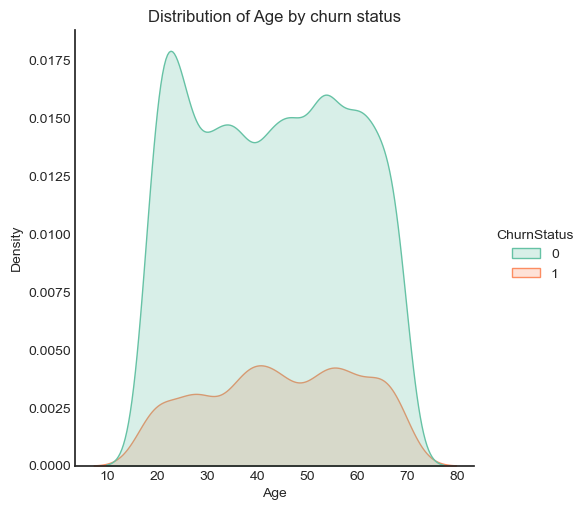

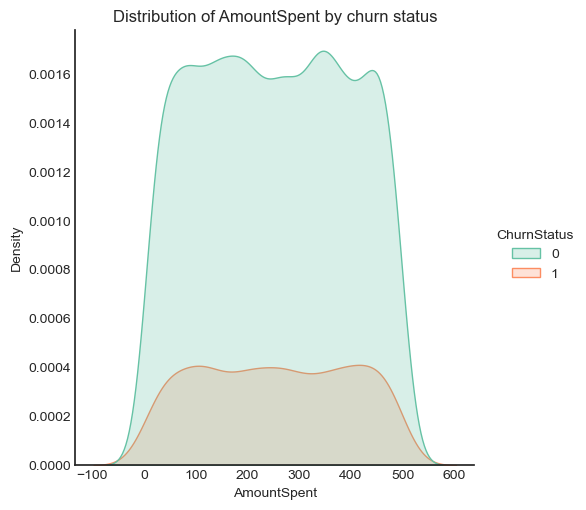

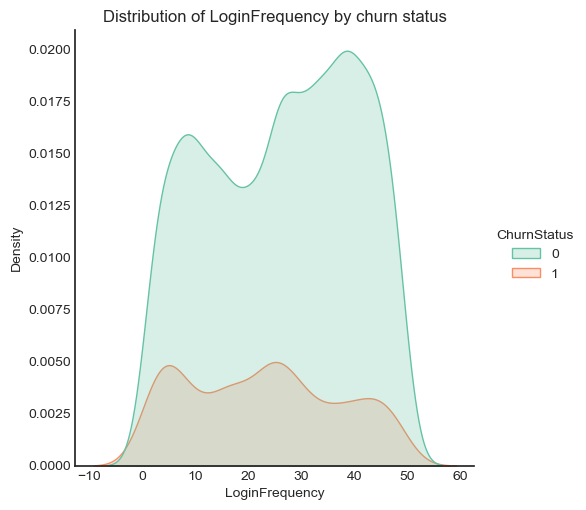

In [47]:
# plotting distribution of numeriacal features by churn status
for i, col in enumerate(numerical_cols):
    sns.displot(bank_df, x=col, palette = 'Set2', hue='ChurnStatus',kind='kde',fill=True)
    plt.title(f'Distribution of {col} by churn status')
plt.show()


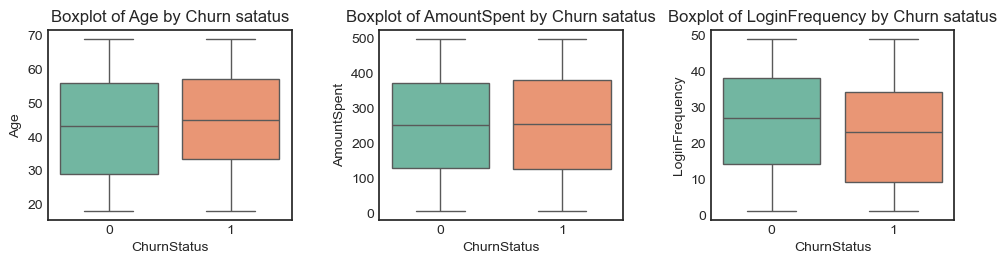

In [287]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i, col in enumerate(numerical_cols):
    sns.boxplot(bank_df, x='ChurnStatus', y=col, ax=axes[i], palette='Set2')
    axes[i].set_title(f"Boxplot of {col} by Churn satatus")
plt.tight_layout(w_pad=3, pad=2)
plt.show()

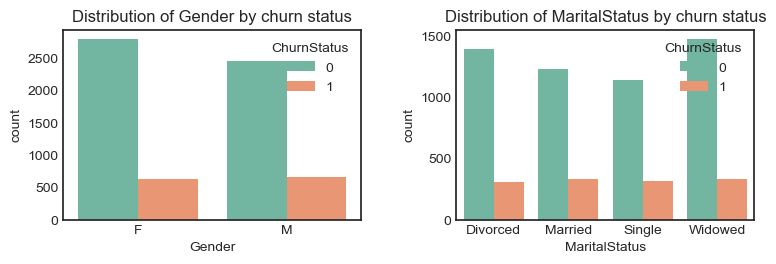

In [289]:
# distribution for age and marital status by churn 
fig, axes = plt.subplots(1,2, figsize=(8, 3))
axes = axes.flatten()
for i, col in enumerate(nominal_cols[:2]):
    sns.countplot(bank_df, x=col, ax=axes[i], hue='ChurnStatus', palette='Set2')
    axes[i].set_title(f'Distribution of {col} by churn status')
plt.tight_layout(w_pad=3, pad=2)
plt.show()

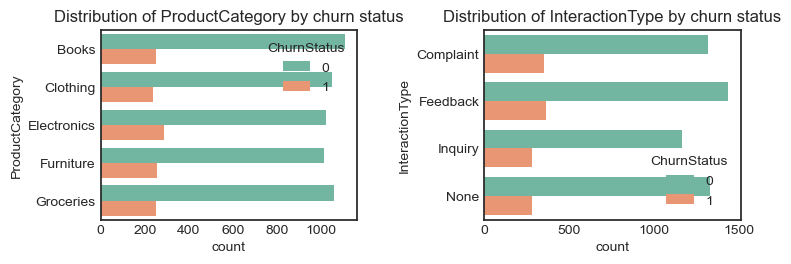

In [291]:
# distribution for product category and interaction type by churn 
fig, axes = plt.subplots(1,2, figsize=(8, 3))
axes = axes.flatten()
for i, col in enumerate(nominal_cols[2:4]):
    sns.countplot(bank_df, y=col, ax=axes[i], hue='ChurnStatus', palette='Set2')
    axes[i].set_title(f'Distribution of {col} by churn status')
plt.tight_layout(w_pad=3, pad=2)
plt.show()

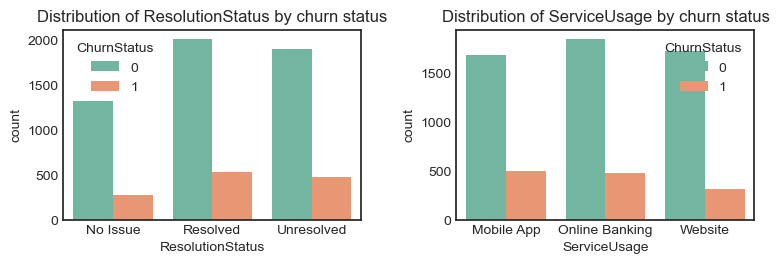

In [293]:
# distribution for Resolution status  and Service usage by churn 
fig, axes = plt.subplots(1,2, figsize=(8, 3))
axes = axes.flatten()
for i, col in enumerate(nominal_cols[4:6]):
    sns.countplot(bank_df, x=col, ax=axes[i], hue='ChurnStatus', palette='Set2')
    axes[i].set_title(f'Distribution of {col} by churn status')
plt.tight_layout(w_pad=3, pad=2)
plt.show()

#### Bivariate Analysis

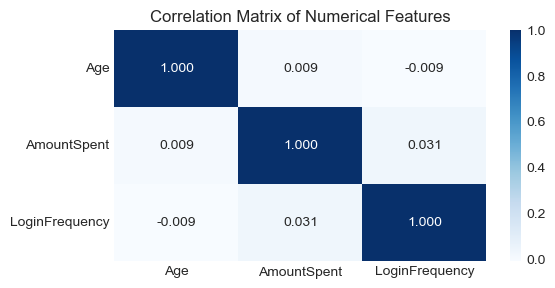

In [275]:
# correlation analysis of numerical features
plt.figure(figsize=(6, 3))
sns.heatmap(bank_df[numerical_cols].corr(), annot=True, fmt='.3f', cmap='Blues')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

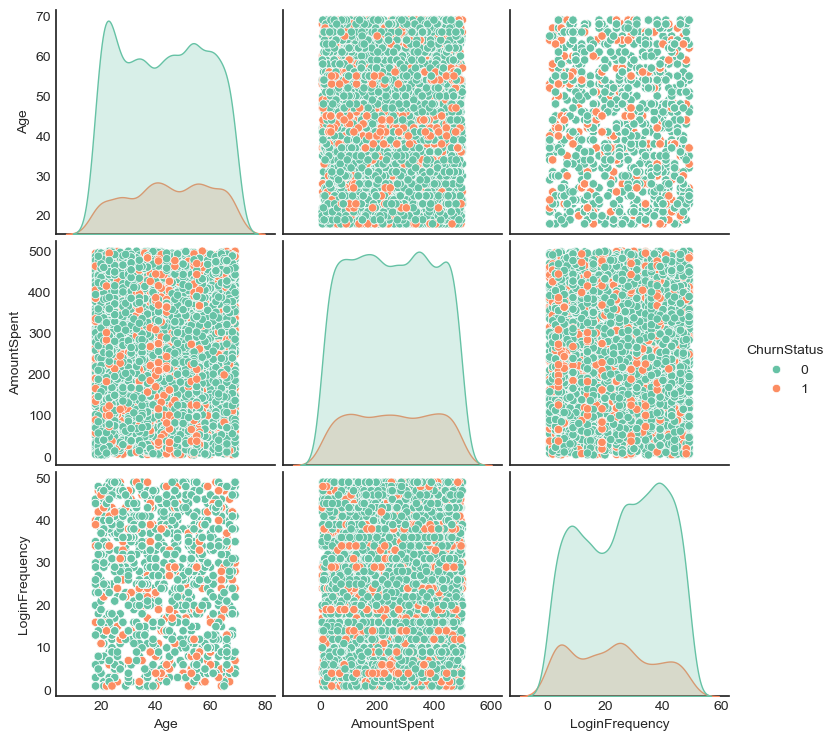

In [345]:
#pair plot of numerical features by churn
sns.pairplot(bank_df, hue='ChurnStatus', palette='Set2')
plt.show()

## PreProcessing

In [54]:
#setting random state
random = 123

#### Train-Test Split

In [56]:
# spliiting the target feature from the data
X = bank_df.drop('ChurnStatus', axis=1)
y = bank_df['ChurnStatus']

In [57]:
X.shape

(6528, 10)

In [58]:
# splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.3, 
    random_state=random, 
    stratify=y)

In [59]:
X_train.shape

(4569, 10)

In [60]:
X_test.shape

(1959, 10)

#### Standardizng

In [62]:
#Instantiating the scaler
scaler = StandardScaler()

In [63]:
# Scaling numerical features
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

#### Encoding

In [65]:
# Instantiating OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories= [['Low', 'Medium', 'High']])

In [66]:
# Ordinal Encoding the ordinal columns- Using OrdinalEncoder
X_train[['IncomeLevel']] = ordinal_encoder.fit_transform(X_train[['IncomeLevel']])
X_test[['IncomeLevel']] = ordinal_encoder.transform(X_test[['IncomeLevel']])

In [67]:
# Instantiating the encoder
ohe = OneHotEncoder(drop='first', sparse_output=False)

In [68]:
# Encoding train and test categorical features
nominal_train = ohe.fit_transform(X_train[nominal_cols])
nominal_test = ohe.transform(X_test[nominal_cols])

In [69]:
# encoded column names
encoded_columns = ohe.get_feature_names_out(nominal_cols)
encoded_columns

array(['Gender_M', 'MaritalStatus_Married', 'MaritalStatus_Single',
       'MaritalStatus_Widowed', 'ProductCategory_Clothing',
       'ProductCategory_Electronics', 'ProductCategory_Furniture',
       'ProductCategory_Groceries', 'InteractionType_Feedback',
       'InteractionType_Inquiry', 'InteractionType_None',
       'ResolutionStatus_Resolved', 'ResolutionStatus_Unresolved',
       'ServiceUsage_Online Banking', 'ServiceUsage_Website'],
      dtype=object)

In [70]:
X_train[encoded_columns] = nominal_train
X_train = X_train.drop(columns=['Gender','MaritalStatus','ProductCategory','InteractionType','ResolutionStatus','ServiceUsage'], axis=1)
X_train.shape

(4569, 19)

In [71]:
X_train.head()

,Age,IncomeLevel,AmountSpent,LoginFrequency,Gender_M,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,ProductCategory_Clothing,ProductCategory_Electronics,ProductCategory_Furniture,ProductCategory_Groceries,InteractionType_Feedback,InteractionType_Inquiry,InteractionType_None,ResolutionStatus_Resolved,ResolutionStatus_Unresolved,ServiceUsage_Online Banking,ServiceUsage_Website
1032,0.970018,2.0,0.663594,1.598447,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
163,-0.145763,0.0,1.657084,-0.674712,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
704,1.495091,1.0,1.089738,-1.598182,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4792,-0.014494,0.0,-1.203170,0.888085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,1.429457,0.0,0.411401,-1.456110,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [72]:
X_test[encoded_columns] = nominal_test
X_test = X_test.drop(columns=['Gender','MaritalStatus','ProductCategory','InteractionType','ResolutionStatus','ServiceUsage'])
X_test.shape

(1959, 19)

#### Class Imbalance

In [74]:
# instantiating the oversampler
smote = SMOTE(random_state=random)

In [75]:
# Resampling the model
X_train, y_train = smote.fit_resample(X_train,y_train)

In [76]:
y_train.value_counts()

ChurnStatus
0    3672
1    3672
Name: count, dtype: int64

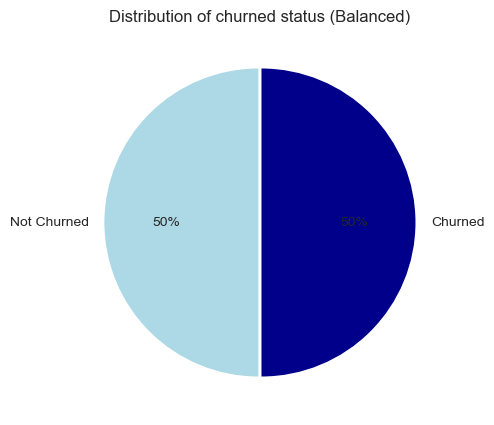

In [295]:
# Pie chart to visualize target.
plt.figure(figsize=(10, 5))
y_train.value_counts(normalize=True).plot.pie(
    autopct='%1.0f%%',
    startangle=90,
    colors=['lightblue', 'darkblue'], 
    labels=['Not Churned', 'Churned'], 
    explode=[0.01, 0.01])
plt.title('Distribution of churned status (Balanced)')
plt.ylabel('')
plt.show()

#### Feature Selection

In [79]:
# Instantiating the Random Forest model as the estimator for RFECV
rf = RandomForestClassifier(random_state=random)

In [80]:
# Instantiating the RFECV for feature selection
rfecv = RFECV(estimator=rf,
    step=4,
    cv=3,
    scoring='f1'  
)
rfecv.fit(X_train, y_train)

RFECV(cv=3, estimator=RandomForestClassifier(random_state=123), scoring='f1',
      step=4)

In [81]:
optimal_features = rfecv.n_features_
selected_features = X_train.columns[rfecv.support_]

In [82]:
optimal_features

19

In [83]:
selected_features

Index(['Age', 'IncomeLevel', 'AmountSpent', 'LoginFrequency', 'Gender_M',
       'MaritalStatus_Married', 'MaritalStatus_Single',
       'MaritalStatus_Widowed', 'ProductCategory_Clothing',
       'ProductCategory_Electronics', 'ProductCategory_Furniture',
       'ProductCategory_Groceries', 'InteractionType_Feedback',
       'InteractionType_Inquiry', 'InteractionType_None',
       'ResolutionStatus_Resolved', 'ResolutionStatus_Unresolved',
       'ServiceUsage_Online Banking', 'ServiceUsage_Website'],
      dtype='object')

## Model 1- KNN

In [85]:
# Insatntiating KNN model
knn_model = KNeighborsClassifier(n_neighbors=4, metric='minkowski', p=2)

In [86]:
# training data based on the optimal selected features
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [87]:
# Predict on the test optimal X_test data 
y_pred_knn = knn_model.predict(X_test)

In [88]:
confusion_matrix(y_test,y_pred_knn)

array([[1391,  183],
       [  66,  319]], dtype=int64)

In [89]:
round(f1_score(y_test,y_pred_knn),4)

0.7193

In [90]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      1574
           1       0.64      0.83      0.72       385

    accuracy                           0.87      1959
   macro avg       0.80      0.86      0.82      1959
weighted avg       0.89      0.87      0.88      1959



### Hyperparameter tuning

In [321]:
# Finding the optimal number of neighbours
f1score = []
k=12
for i in range(1,k+1):
    knn_model_2 = KNeighborsClassifier(n_neighbors=i, metric='minkowski', p=2)
    knn_model_2.fit(X_train, y_train)
    f1score.append(f1_score(y_test, knn_model_2.predict(X_test)))

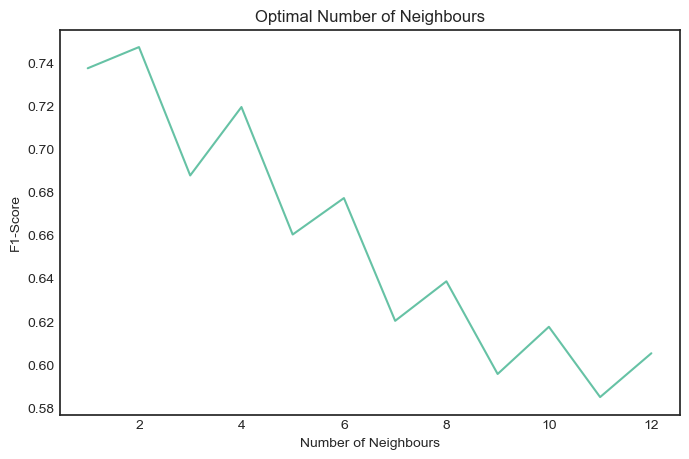

In [325]:
# plotting the optimal number of neighbours
plt.figure(figsize=(8,5))
sns.lineplot(y=f1score, x=range(1,k+1), color='#66C2A5')
plt.title('Optimal Number of Neighbours')
plt.xlabel('Number of Neighbours')
plt.ylabel('F1-Score')
plt.show()

### Optimal KNN Model

In [347]:
# the optimal model has 2 neighhors
knn_model_optimal = KNeighborsClassifier(n_neighbors=2, metric='minkowski', p=2)
knn_model_optimal.fit(X_train, y_train)
y_pred_knn_optimal = knn_model_optimal.predict(X_test)

In [349]:
round(f1_score(y_test,y_pred_knn_optimal),4)

0.7471

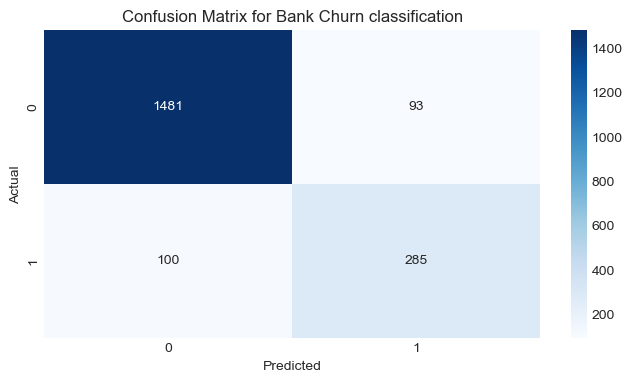

In [361]:
# plotting the confusion matrix
knn_cm = confusion_matrix(y_test, y_pred_knn_optimal)
plt.figure(figsize=(8,4))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Bank Churn classification')
plt.show()

In [353]:
# classification report
print(classification_report(y_test,y_pred_knn_optimal))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1574
           1       0.75      0.74      0.75       385

    accuracy                           0.90      1959
   macro avg       0.85      0.84      0.84      1959
weighted avg       0.90      0.90      0.90      1959



## Model 2 - Random Forest

In [101]:
# Insatntiating random forest model
rf_model = RandomForestClassifier(random_state=random)

In [102]:
# training data 
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [103]:
# Predict on the test optimal X_test data for random forest
y_pred_rf = rf_model.predict(X_test)

In [355]:
# classification report
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1574
           1       0.94      0.75      0.84       385

    accuracy                           0.94      1959
   macro avg       0.94      0.87      0.90      1959
weighted avg       0.94      0.94      0.94      1959



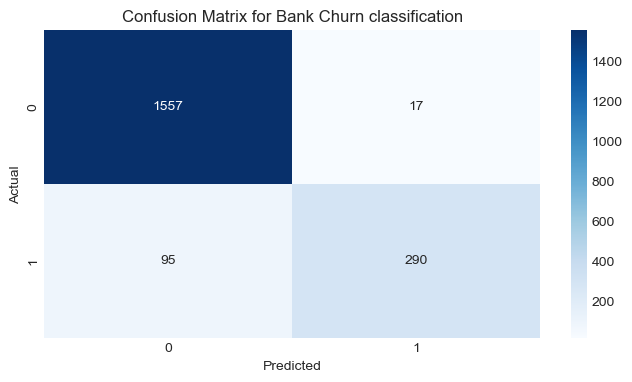

In [359]:
# plotting the confusion matrix for ranfom forest model
rf_cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Bank Churn classification')
plt.show()

In [331]:
# f1-score
f1_score(y_test, y_pred_rf)

0.838150289017341

### Hyper Parameter Tuning

In [387]:
parameters = {
    'n_estimators': [250,260],
    'max_depth' : [10,20]  
}

# instantiating GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=parameters , cv=5, verbose=1, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'n_estimators': [250, 260]},
             scoring='f1', verbose=1)

In [388]:
grid_search.best_params_

{'max_depth': 20, 'n_estimators': 250}

In [389]:
# Predict on the test optimal X_test data for random forest
y_pred_rf_tuned = grid_search.predict(X_test)

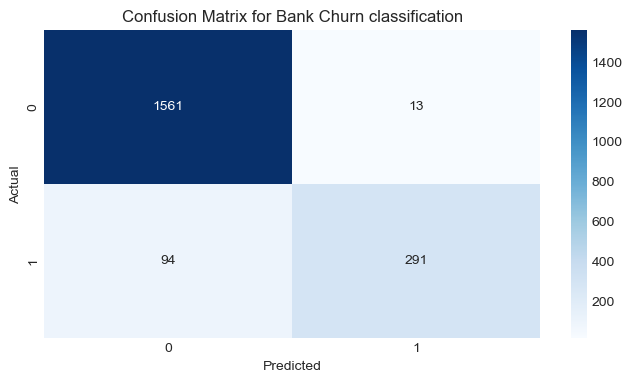

In [390]:
# plotting the confusion matrix
rf_cm_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
plt.figure(figsize=(8, 4))
sns.heatmap(rf_cm_tuned, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Bank Churn classification')
plt.show()

In [391]:
print(classification_report(y_test,y_pred_rf_tuned))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1574
           1       0.96      0.76      0.84       385

    accuracy                           0.95      1959
   macro avg       0.95      0.87      0.91      1959
weighted avg       0.95      0.95      0.94      1959



In [397]:
f1_score(y_test, y_pred_rf_tuned)

0.8447024673439768

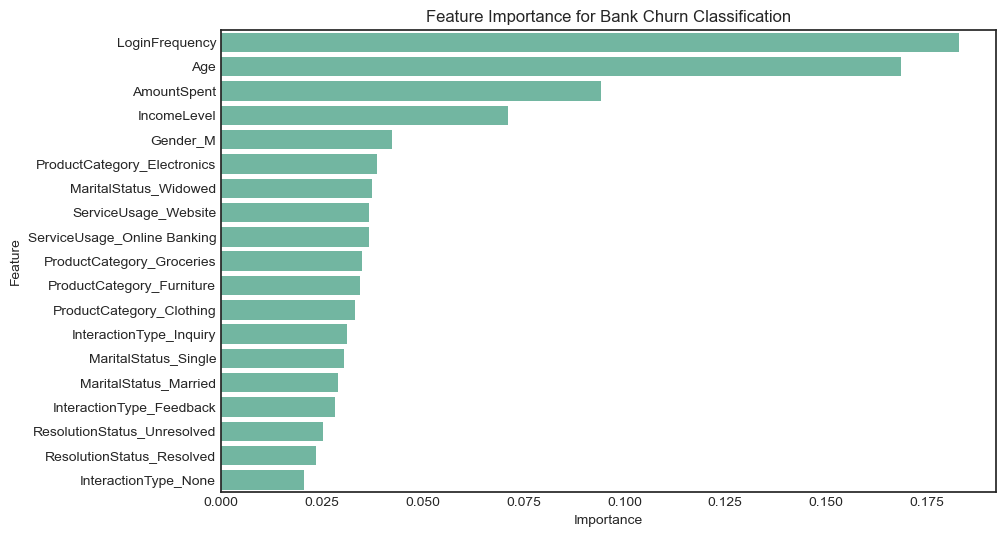

In [337]:
# Feature importance for bank churn
feature_importances = rf_model.feature_importances_
# plotting feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(feature_importance_df, x='Importance',y='Feature',color='#66C2A5')
plt.title('Feature Importance for Bank Churn Classification')
plt.show()